In [265]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit as fit
import scipy.sparse as sci_sparse
import os

from dls_data_extraction import*

#%matplotlib notebook

In [277]:
date = '2021-12-05' # water
#date = '2021-12-06' # dmso
datadir = './tmp/'+date+'/' # sample data directory

In [278]:
solvent = 'water'
sample = '100NP_'
#scans = range(7587,7597)    # scans to run -- NP in water/DMSO in focus
#scans = range(7607,7617)    # scans to run -- NP in water/DMSO 1000um out
#scans = range(7637,7667)    # scans to run -- NP in water/DMSO 2000um out
scans = range(252,552)    # scans to run -- NP in water in focus
exp_time = 5e-7           # exposure time [s]
downsample = 10            # pixel binning
width = 1

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s' #+'_width'+str(width)

g2 = np.load(datadir+sample+solvent+'_g2_'+filename+'.npy')
g2av = np.load(datadir+sample+solvent+'_g2av_'+filename+'.npy')
g2std = np.load(datadir+sample+solvent+'_g2std_'+filename+'.npy')
q = np.load(datadir+sample+solvent+'_q_'+filename+'.npy')
delays = np.load(datadir+sample+solvent+'_delays_'+filename+'.npy')
print(g2av.shape, g2.shape, q)

distance = 4.0 # m
photon_energy = 10.0e3 #eV
h = 4.135667516e-15
c = 2.99792458e8
wavelength = h*c/photon_energy
pix = 55e-6 # pixel size, m

(399, 20) (300, 399, 20) [0.05676936 0.06032793 0.06427809 0.06688745 0.07111541 0.07451499
 0.07851204 0.08113534 0.08475168 0.0883943  0.09212257 0.09525666
 0.09889776 0.1022169  0.10566486 0.1091241  0.11287018 0.11589713
 0.11943115 0.12309645]


### Distribution of contrast

### sort g2 

### Plot data

## Plot average g2

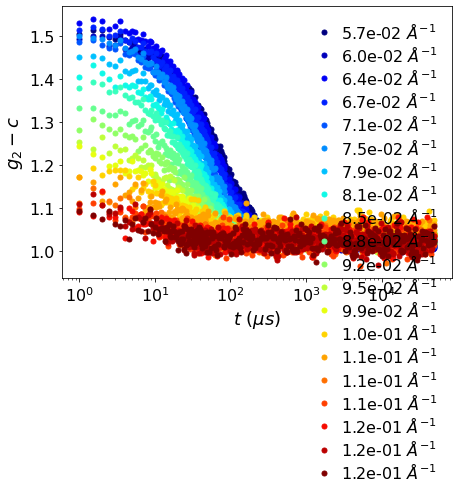

In [279]:
t = delays*exp_time * 1.0e6 # delay time [us]

plt.figure(figsize=(7,5))
col = plt.cm.jet(np.linspace(0,1,len(q)))

for i in range(0,len(q)):
    
    l, = plt.plot(t[1:], g2av[1:, i], 'o', alpha=1.0, ms=5 , color=col[i], label=r'%.1e $\AA^{-1}$' %q[i])
    #plt.errorbar(t[1:], g2av[1:, i], yerr=g2std[1:, i], color=l.get_color(), fmt='o', ms=3 ) #,label=r'%.1e $\AA^{-1}$' %q[i])
    
plt.xlabel('$t ~(\mu s)$', size=18)
plt.ylabel(r'$g_2-c$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.1)
plt.tick_params(labelsize=16)

plt.show()

## Fit g2 and plot

44.816611622760966 0.9129507989542908
52.30882234550388 0.8057404580523415
61.96937655292316 0.8562779379669909
70.8475798379333 0.8951333138589113
78.65062732140137 0.9008169541778862
89.15505875303612 0.8959189445104245
95.15107130745912 0.8857779718050567
109.54757356526649 0.9021833492939679
117.45940483623315 0.891669892509429
136.88109699160574 0.8805361704690368
152.72918834910314 0.8674657414583158
contrast: [0.20348312444409472, 0.24740182959026305, 0.2902790609090701, 0.32522414997628846, 0.37425228200966015, 0.41004587724836605, 0.44344081416835296, 0.48584317121574905, 0.49487637204431295, 0.5212714375700308, 0.5417409018539221]


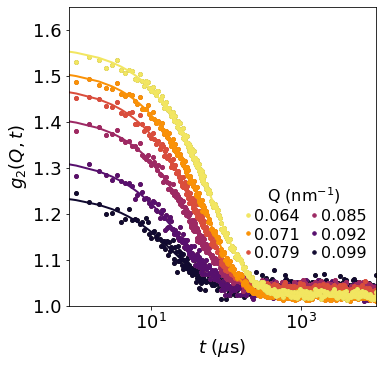

In [280]:
from scipy.special import gamma, polygamma
from scipy.optimize import curve_fit

def exponential(x, a , b):
    return np.abs(a)*np.exp(-2*x/np.abs(b)) #+ baseline

def stretched_exponential(x, a , b, c):
    return np.abs(a)*np.exp(-2*(x/np.abs(b))**c) #+ baseline

fun = 2 # choose fit function

if fun == 1:
    fit_func = exponential
elif fun == 2:
    fit_func = stretched_exponential
elif fun == 3:
    fit_func = exponential2
    
N=7 # no of high q values to omit

col = plt.cm.inferno_r(np.linspace(-0.1,1,len(q)+1-N))

plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
beta=[]
unit = 1e6
t = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit

p = np.arange(2,len(q)-N)
u=0

for i in range(len(q)-N-1,1,-1): # plot decreasing q
    
    bg = np.nanmean(g2av[300:,i])
    
    # Data range to fit
    #tend=tstart
    #while (g2av[tend, i]-bg) > (g2av[tstart, i]-bg)*1/3: 
    #    tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, i]-bg, sigma=g2std[tstart:tend, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print(popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, i]-bg, sigma=g2std[tstart:tend, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,1)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
  
    beta.append(popt[0])
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q[i])
    qind.append(i)
    
    if i % 2 == 0: # plot every 2nd q
        plt.plot(t[1:], g2av[1:, i], 'o', ms=3.5 , color=col[p[u]], label=r'%.3f' %q[p[u]])
        plt.plot(t[1:], g2av[1:,i],'o', ms=4, color=col[i])
        #plt.plot(t[1:], (g2av[1:, i]-bg)/popt[0], 'o', ms=4 , color=col[i], label=r'%.3f' %q[i]) # normalized r'
        #plt.errorbar(t, g2av[:, i]-bg, yerr=g2std[:, i], color=col[i], fmt='o', ms=5) #, label=r'%.3f $nm^{-1}$' %q[i])
        plt.plot(tt, (fit_func(tt, *popt)+bg), color=col[i], linestyle='-', lw=2)
        #plt.plot(tt, (fit_func(tt, *popt))/popt[0], color=col[i], linestyle='-', lw=2) # normalized
    #plt.plot(np.array([t[tend], t[tend]]), [-0.05, 1.0],'--', c='grey', alpha=0.5) # plot vertical line marking the end of the fit range
    u+=1

plt.xlabel('$t$ ($\mu$s)', size=18)
plt.ylabel(r'$g_2(Q,t)$', size=18)
#plt.ylabel(r'$(g_2-c)/\beta$', size=18)
plt.xscale('log', nonpositive='clip')
legend = plt.legend(frameon=False, loc='lower right', fontsize=16, labelspacing=0.2, handletextpad=0.0, handlelength=0.8, borderpad=0.1, 
                    ncol=2, columnspacing=.5, bbox_to_anchor=(1.,0.12))
legend.set_title(r'Q (nm$^{-1}$)') 
legend.get_title().set_fontsize('16')
plt.tick_params(labelsize=18)
#plt.title(r'%.4f $\AA^{-1}$' %q[i], size=18)
plt.xlim([8e-7*unit,10e-3*unit])
plt.ylim([1.0,1.65])

print('contrast:',beta)

#plt.savefig('g2fit_contrast_'+sample+solvent+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight')# save plot

plt.show()

## Q-dependence

fun 2
Q-exponent: 2.4092437130191886
34.583425259355245 0.4092437130191886 1.237902316034906e+18
D: 1.6018231171000119e-12 +- 2.5206315560526923e-14 m^2/s


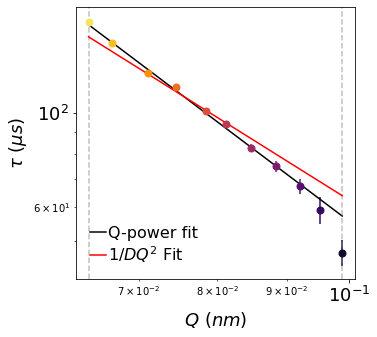

[0.09889776189283866, 0.095256660562808, 0.09212256818164052, 0.08839429637328979, 0.08475168369037077, 0.08113533563085039, 0.07851203940359536, 0.0745149872914487, 0.07111541054674533, 0.06688745273512944, 0.06427808621839916]


In [281]:
tau = np.array(tau) # us
tau_errors = np.array(tau_errors)
qq = np.array(qs)*1e9 # 1/m
x = qq # 1/m

if fun==1: 
    y = tau/unit # s
    yerr = tau_errors/unit # s
    print('fun 1')
elif fun==2: 
    kww = np.array(kww)
    kww_errors = np.array(kww_errors)
    y = (tau / kww * gamma(1/kww))/unit # s
    yerr = (tau_errors * np.abs(1/kww) + kww_errors * np.abs(-tau/kww**2 * gamma(1/kww) + tau/kww * -1/kww**2 * gamma(1/kww)*polygamma(0,1/kww)))/unit # s
    print('fun 2')

# fit range
a = 0
b = -1

################### fit log(tau) vs log(q) #######################

def tau_fit(x,a,b):
    return -a*x + b # q-dependence fit

fig, ax = plt.subplots(figsize=(5,5))

for i in range(len(x)):
    ax.errorbar(x[i]/1e9, y[i]*unit, yerr=yerr[i]*unit, fmt='o', ms=7, color=col[qind[i]])

popt, pcov = curve_fit(tau_fit, np.log(x[a:b]), np.log(y[a:b]), sigma=yerr[a:b]/y[a:b], p0=[2,1]) 
perr = np.sqrt(np.diag(pcov))
print('Q-exponent:',popt[0])
print(popt[1], popt[0]-2, np.exp(popt[1]*(popt[0]/2)))

xx = np.linspace(x[-1],x[0])
ax.plot(xx/1e9, np.exp(tau_fit(np.log(xx), *popt))*unit,'k-', lw=1.5, label=r'Q-power fit') 
ax.axvline(x[a]/1e9, ls='--', color='grey', alpha=0.5)
ax.axvline(x[b]/1e9, ls='--', color='grey', alpha=0.5) 

##################### fit tau vs q^-2 ####################

def tau_fit2(x,a):
    return (1/a)*x  

popt2, pcov2 = curve_fit(tau_fit2, 1/x[a:b]**(2), y[a:b], sigma=yerr[a:b], p0=[1e-12]) 
perr2 = np.sqrt(np.diag(pcov2)/1) # one g2 fit
D = popt2[0] # diffusion coefficient, m^2/s
Derr = perr2[0] # standard error
print('D:',D,'+-', Derr, 'm^2/s') 

xx = np.linspace(x[-1],x[0])
ax.plot(xx/1e9, tau_fit2(1/xx**(2), *popt2)*unit,'r-', lw=1.5, label=r'$1/DQ^2$ Fit')
ax.set_xlabel(r'$Q ~(nm)$', size=18)
ax.set_ylabel(r'$\tau ~(\mu s)$', size=18)
ax.tick_params(labelsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1, handlelength=1)
plt.show()

#print([np.flip(x)/1e9, np.flip(y)*unit, np.flip(yerr)*unit])
#np.save('tau_data_water', [np.flip(x)/1e9, np.flip(y)*unit, np.flip(yerr)*unit])

print(qs)

### Plot tau Q-dependence for paper

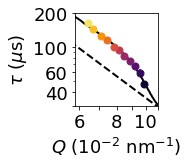

In [283]:
# import model values:
if solvent=='water':
    Q_av_tau = np.load('Q_av_tau_NPwater.npy')
    tau_av = np.load('tau_av_NPwater.npy')
    tau0_av = np.load('tau0_av_NPwater.npy')
elif solvent=='dmso':
    Q_av_tau = np.load('Q_av_tau_NPdmso.npy')
    tau_av = np.load('tau_av_NPdmso.npy')
    tau0_av = np.load('tau0_av_NPdmso.npy')

fig, ax = plt.subplots(figsize=(1.5,1.7))

for i in range(len(x)):
    ax.errorbar(x[i]/1e9*1e2, y[i]*unit, yerr=yerr[i]*unit, fmt='o', ms=7, color=col[qind[i]])

# convoluted model tau
plt.plot(Q_av_tau[:]*1e2,tau_av[:]*1e6, 'k-', lw=2, label=r'$\tau_{model, conv.}$') # color='dodgerblue',
plt.plot(Q_av_tau[:]*1e2,tau0_av[:]*1e6, 'k--', lw=2, label=r'$\tau_{model}$')

ax.set_xlabel(r'$Q$ ($10^{-2}$ nm$^{-1}$)', size=18)
ax.set_ylabel(r'$\tau$ ($\mu$s)', size=18)
ax.tick_params(labelsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['','6','','8','','10','','12'])
ax.set_yticks([30, 40, 60, 100, 200, 300])
ax.set_yticklabels(['','40','60','100', '200', ' '])
plt.xlim([5.8,11])
plt.ylim([3e1,2e2])

#plt.savefig('tau_'+sample+solvent+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

### KWW exponent

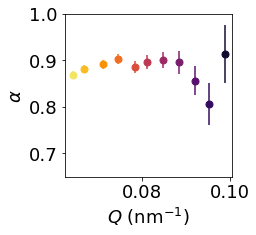

In [1401]:
plt.figure(figsize=(3,3))

for i in range(0,len(x),1):
    plt.errorbar(x[i]/1e9, kww[i], yerr=kww_errors[i], fmt='o', ms=7, color=col[qind[i]])

plt.xlabel(r'$Q$ (nm$^{-1})$', size=18)
plt.ylabel(r'$\alpha$', size=18)
plt.tick_params(labelsize=18)
plt.ylim([0.65,1.])

#plt.savefig('kww_'+sample+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

In [1402]:
kww_av = np.average(kww, weights=1/kww_errors**2) 
kww_std = np.sqrt(np.average((kww-kww_av)**2, weights=1/kww_errors**2))
print(kww, kww_errors, kww_av, kww_std)

[0.9129508  0.80574046 0.85627794 0.89513331 0.90081695 0.89591894
 0.88577797 0.90218335 0.89166989 0.88053617 0.86746574] [0.06243231 0.04534524 0.03105745 0.02424372 0.01753937 0.01476349
 0.01271185 0.01018349 0.00959714 0.00879067 0.00855151] 0.8850462405269446 0.014422267999318906


### Viscosity for water and DMSO mixture

[1.35750647e-04 2.25528200e+02 1.65853387e+00]


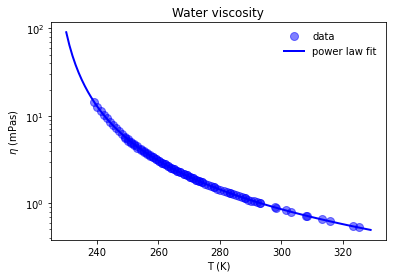

In [1403]:
ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # mPas, water viscosity from dehaoui et al.
ndata_w2 = np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat', delimiter=',') # mPas, macroscopic water viscosity 
ndata_w = np.vstack((ndata_w1,ndata_w2))

popt_w,pcov_w = fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4, 220, 2]) # Pas
print(popt_w)

T_range = np.linspace(230,330,100) # K

plt.figure()
plt.plot(ndata_w[:,0],ndata_w[:,1],'o',c='b',alpha=0.5,ms=8,label='data')
plt.plot(T_range[0:-1],power_law(T_range[0:-1],*popt_w)*1e3,c='b',ls='-',lw=2 ,label='power law fit')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\eta$ (mPas)')
plt.title(r'Water viscosity')
plt.legend(frameon=False)
plt.yscale('log')

#plt.savefig('water_viscosity.png') # save plot

plt.show()

[1.11734278e-03 1.61149938e+02 5.50173348e+00]
[3.57291777e-04 2.13028775e+02 2.56430758e+00]


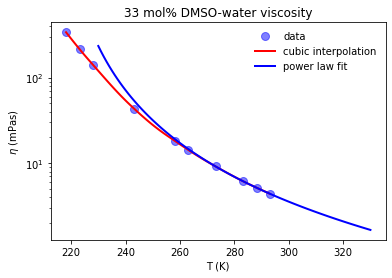

In [1404]:
from scipy.interpolate import interp1d

# dmso/water viscosity
n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # Pas, 33 mol% dmso
T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15; # K 
# schichman, jpc 1971

popt_dmso,pcov_dmso = fit(power_law,T_dmso,n_dmso,p0=[1e-3, 200, 5]) 
f_dmso = interp1d(T_dmso, n_dmso, kind='cubic')
print(popt_dmso)

T_range = np.linspace(T_dmso[0], T_dmso[-1], num=100, endpoint=True)

plt.figure()
plt.plot(T_dmso,n_dmso*1e3,'o',c='b',alpha=0.5,ms=8,label='data')
plt.plot(T_range,f_dmso(T_range)*1e3,c='r',ls='-',lw=2 ,label='cubic interpolation')

# power law
popt_dmso_power,pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:],p0=[1e-4, 200, 3]) # Pas
print(popt_dmso_power)
TT_range = np.linspace(230,330,100) # K
plt.plot(TT_range,power_law(TT_range,*popt_dmso_power)*1e3,c='b',ls='-',lw=2 ,label='power law fit')

plt.xlabel(r'T (K)')
plt.ylabel(r'$\eta$ (mPas)')
plt.title(r'33 mol% DMSO-water viscosity')
plt.legend(frameon=False)
plt.yscale('log')

#plt.savefig('33dmso_viscosity.png') # save plot

plt.show()

### Estimate Rh

In [1405]:
T = 295 # K
k = 1.38064852e-23

if solvent=='water':
    Rh = k*T/(6*np.pi*D*power_law(T,*popt_w))*1e9 # radius in nm, water
    Rh_err = k*T/(6*np.pi*power_law(T,*popt_w)) * 1/D**2 * Derr * 1e9
elif solvent=='dmso':           
    Rh = k*T/(6*np.pi*D*power_law(T,*popt_dmso_power))*1e9 # dmso-water
    Rh_err = k*T/(6*np.pi*power_law(T,*popt_dmso_power)) * 1/D**2 * Derr * 1e9

print(Rh, Rh_err)

140.95682498052977 4.3474739869600905


## Compare different measurements

In [284]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7587,7597)    # scans to run -- NP in water/DMSO in focus
exp_time = 5e-6           # exposure time [s]
downsample = 10            # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av1 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std1 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q1 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays1 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [285]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7607,7617)    # scans to run -- NP in water/DMSO 1000um out
exp_time = 5e-6           # exposure time [s]
downsample = 10            # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av2 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std2 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q2 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays2 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [286]:
date = '2021-12-06'
datadir = './tmp/'+date+'/' # data directory

sample = '100NP_dmso'
scans = range(7637,7667)    # scans to run -- NP in water/DMSO 2000um out
exp_time = 5e-6           # exposure time [s]
downsample = 10            # pixel binning

filename = str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s'

g2av3 = np.load(datadir+sample+'_g2av_'+filename+'.npy')
g2std3 = np.load(datadir+sample+'_g2std_'+filename+'.npy')
q3 = np.load(datadir+sample+'_q_'+filename+'.npy')
delays3 = np.load(datadir+sample+'_delays_'+filename+'.npy')

In [287]:
g2av = np.empty((len(delays1),len(q1),3))
g2std = np.empty((len(delays1),len(q1),3))
q = q1 
delays = delays1

g2av[:,:,0] = g2av1 
g2av[:,:,1] = g2av2
g2av[:,:,2] = g2av3 

g2std[:,:,0] = g2std1 
g2std[:,:,1] = g2std2 
g2std[:,:,2] = g2std3 

# beam divergence
divergence = 1.2e-3 # divergence, rad
s1 = 88e-9 # focus size, m
distance = np.array([0, 1000e-6, 2000e-6])
beamsize = np.tan(divergence/2) * 2 * distance + s1 # beam size (fwhm) on detector, m
beam = np.round(np.array([beamsize[0]*1e9, beamsize[1]*1e6, beamsize[2]*1e6]),1)
print('beam sizes:', beam)
beam_unit = ['nm','$\mu$m','$\mu$m']

alpha = [1, 0.5, 0.2]

print(g2av.shape, len(g2av[0,0,:]))

beam sizes: [88.   1.3  2.5]
(399, 20, 3) 3


## fit g2 vs beam size

520.5259280335104 0.8238115880966617
510.647190893729 0.8235563537385961
498.2458409094312 0.8471488803931795


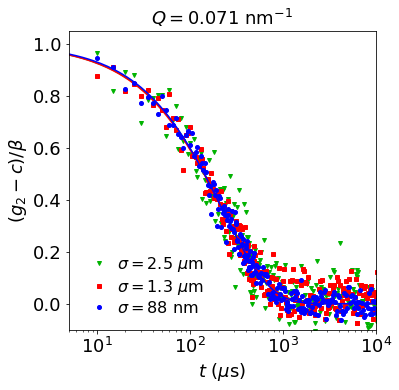

In [288]:
from scipy.special import gamma, polygamma
from scipy.optimize import curve_fit

fun = 2 # choose fit function
j = 4 # choose Q

if fun == 1:
    fit_func = exponential
elif fun==2:
    fit_func = stretched_exponential


plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
unit = 1e6
t = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit
symbol = ['o','s','v']
col = ['b','r',[0,0.7,0]]

for i in [2, 1, 0]:
    
    bg = np.mean(g2av[300:,j,i])
    
    # Data range to fit
    #tend=tstart
    #while (g2av[tend, j, i]-bg) > (g2av[tstart, j, i]-bg)*1/3: 
    #    tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print(popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
    
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q[i])
    qind.append(i)
    
    if i==0:
        l, = plt.plot(t[1:], (g2av[1:, j, i]-bg)/popt[0], symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.d$ nm' %(beam[i]))
    else:
        l, = plt.plot(t[1:], (g2av[1:, j, i]-bg)/popt[0], symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.1f$ $\mu$m' %(beam[i]))
    plt.plot(tt, fit_func(tt, *popt)/popt[0], color=l.get_color(), linestyle='-', lw=1.5)
    
#plt.plot(np.array([t[tend], t[tend]]), [-0.1, 0.6],'-', c='k') # plot vertical line marking the end of the fit range

plt.xlabel('$t$ ($\mu$s)', size=18)
#plt.ylabel(r'$g_2-c$', size=18)
#plt.ylabel(r'$g_2$ (norm.)', size=18)
plt.ylabel(r'$(g_2-c)/\beta$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1)
plt.tick_params(labelsize=18)
plt.title(r'$Q = %.3f$ nm$^{-1}$' %q[j], size=18)
plt.xlim([5e-6*unit,1e-2*unit])
plt.ylim([-0.1,1.05])

#plt.savefig('g2fit_beam_size_dmso_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=200, bbox_inches='tight',)# save plot

plt.show()

### with contrast

498.2458409094312 0.8471488803931795
510.647190893729 0.8235563537385961
520.5259280335104 0.8238115880966617


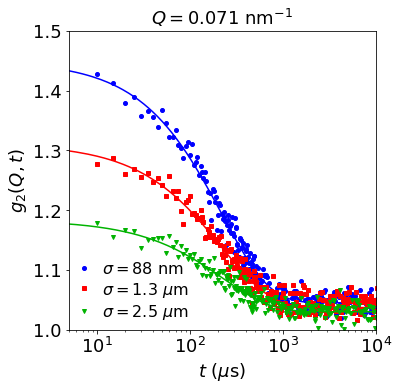

In [289]:
from scipy.special import gamma, polygamma
from scipy.optimize import curve_fit

fun = 2 # choose fit function
j = 4 # choose Q

if fun == 1:
    fit_func = exponential
elif fun==2:
    fit_func = stretched_exponential


plt.figure(figsize=(5.5,5.5)) # for paper

tstart = 1
tau = []
tau_errors = []
kww = []
kww_errors = []
qs = []
qind = []
beta = []
unit = 1e6
t = delays*exp_time * unit # delay time [us]
tt = np.concatenate((np.linspace(0,1,10), np.logspace(0,5,200).astype(int)), axis=None)*1e-6*unit
symbol = ['o','s','v']
col = ['b','r',[0,0.7,0]]


for i in [0, 1, 2]:
    
    bg = np.mean(g2av[300:,j,i])
    
    # Data range to fit
    #tend=tstart
    #while (g2av[tend, j, i]-bg) > (g2av[tstart, j, i]-bg)*1/3: 
    #    tend+=1 
    tend=-1
   
    if fun == 1: # simple exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 100], bounds=((0,0),(np.inf,np.inf)))
        perr = np.sqrt(np.diag(pcov))
        print(popt[1])
    elif fun==2: # kww exponential fit
        popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 100, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
        kww.append(popt[2])
        kww_errors.append(perr[2])
        print(popt[1], popt[2])
    
    beta.append(popt[0])
    tau.append(popt[1])
    tau_errors.append(perr[1])
    qs.append(q[i])
    qind.append(i)
    
    if i==0:
        l, = plt.plot(t[1:], (g2av[1:, j, i]), symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.d$ nm' %(beam[i]))
    else:
        l, = plt.plot(t[1:], (g2av[1:, j, i]), symbol[i], color=col[i], ms=4 , label=r'$\sigma = %.1f$ $\mu$m' %(beam[i]))
    plt.plot(tt, fit_func(tt, *popt)+bg, color=l.get_color(), linestyle='-', lw=1.5)
    
#plt.plot(np.array([t[tend], t[tend]]), [-0.1, 0.6],'-', c='k') # plot vertical line marking the end of the fit range

plt.xlabel('$t$ ($\mu$s)', size=18)
plt.ylabel(r'$g_2(Q,t)$', size=18)
plt.xscale('log', nonpositive='clip')
plt.legend(frameon=False, loc='lower left', fontsize=16, labelspacing=0.2, handletextpad=0.1, bbox_to_anchor=[-0.05,-0.02])
plt.tick_params(labelsize=18)
plt.title(r'$Q = %.3f$ nm$^{-1}$' %q[j], size=18)
plt.xlim([5e-6*unit,1e-2*unit])
plt.ylim([1.0,1.5])

#plt.savefig('g2fit_contrast_beam_size_dmso_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=200, bbox_inches='tight')# save plot

plt.show()

### contrast vs beam size

[5.63564514 0.38504403 0.19933148] [10.24662752  0.70008006  0.36242087]
contrast [0.4039265648796642, 0.2738126072580635, 0.15324967555253033]


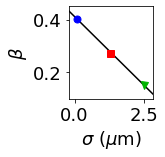

In [290]:
L=4.0
b=np.linspace(-1,3e-6,100)
speckle_size = wavelength*L/beamsize
sp = speckle_size/(pix*10)
print(speckle_size*1e3, sp)
print('contrast',beta)

def line(x, a, b):
    return a*x+b
    
popt, pcov = curve_fit(line, beamsize, beta)

fig, ax = plt.subplots(figsize=(1.5,1.7))

ax.plot(b*1e6, line(b,*popt),'k-')

for i in range(3):
    
    ax.plot(beamsize[i]*1e6, beta[i], symbol[i], color=col[i], ms=7)
    
ax.set_xlabel(r'$\sigma$ ($\mu$m)', size=18)
ax.set_ylabel(r'$\beta$', size=18)
ax.tick_params(labelsize=18)
ax.set_xlim([-0.2, 2.8])
ax.set_ylim([0.1, 0.45])
#ax.set_xscale('log')
#ax.set_yscale('log')

plt.savefig('contrast_beam.png', dpi=300, bbox_inches='tight')

plt.show()

## fit all Q:s and beam sizes

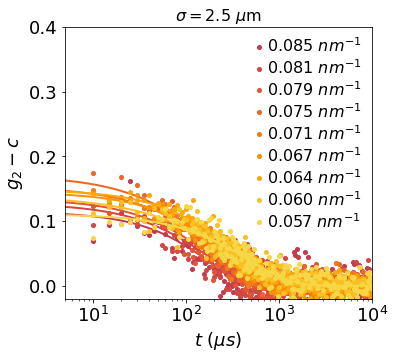

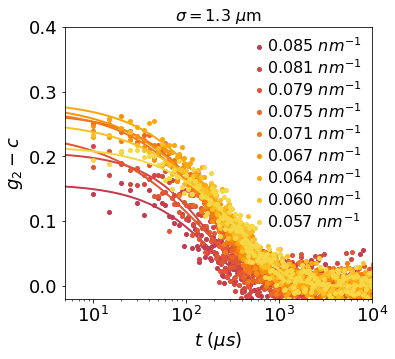

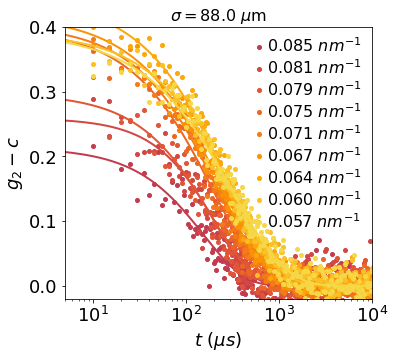

[[796.95752036 909.04546342 979.7097315 ]
 [725.89451245 828.891994   863.67630754]
 [637.03465595 664.08393921 693.74368968]
 [569.05476302 607.60579747 556.77660375]
 [498.2458426  510.64765998 520.52611385]
 [451.5045487  487.63517335 441.51481608]
 [386.33223287 390.50027874 391.12563957]
 [388.07929082 363.33157699 368.05581576]
 [310.73755691 357.22341006 323.08653394]] [[0.05676936 0.05676936 0.05676936]
 [0.06032793 0.06032793 0.06032793]
 [0.06427809 0.06427809 0.06427809]
 [0.06688745 0.06688745 0.06688745]
 [0.07111541 0.07111541 0.07111541]
 [0.07451499 0.07451499 0.07451499]
 [0.07851204 0.07851204 0.07851204]
 [0.08113534 0.08113534 0.08113534]
 [0.08475168 0.08475168 0.08475168]]


In [291]:
N = 11

sample = ['100NP_dmso_88','100NP_dmso_1300','100NP_dmso_2300']

tstart = 1
col = plt.cm.inferno_r(np.linspace(0.1,1,len(q)))
tau = np.empty((len(q1)-N,3))
tau_errors = np.empty((len(q1)-N,3))
kww =np.empty((len(q1)-N,3))
kww_errors = np.empty((len(q1)-N,3))
qs = np.empty((len(q1)-N,3))

for i in [2, 1, 0]:
    
    plt.figure(figsize=(5.5,5)) 
    
    for j in range(len(q)-N-1,-1,-1):
    
        bg = np.mean(g2av[300:, j, i])
        
        # Data range to fit:
        #tend=tstart
        #while (g2av[tend, j, i]-bg) > (g2av[tstart, j, i]-bg)*1/3: 
        #    tend+=1 
        tend=-1
   
        if fun == 1: # simple exponential fit
            popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 300], bounds=((0,0),(np.inf,np.inf)))
        elif fun==2: # kww exponential fit
            popt, pcov = curve_fit(fit_func, t[tstart:tend], g2av[tstart:tend, j, i]-bg, sigma=g2std[tstart:tend, j, i], p0=[0.3, 300, 1], bounds=((0,0,0),(np.inf,np.inf,2)))
        perr = np.sqrt(np.diag(pcov))
    
        tau[j, i] = popt[1]
        tau_errors [j, i] = perr[1]
        if fun == 2:
            kww[j, i] = popt[2]
            kww_errors [j, i] = perr[2]
        qs[j, i] = q[j]

        plt.plot(t[1:], (g2av[1:, j, i]-bg), 'o', ms=4 , color=col[j], label=r'%.3f $nm^{-1}$' %q[j]) # normalized r'
        plt.plot(tt, (fit_func(tt, *popt)), color=col[j], linestyle='-', lw=2) # normalized
    
        plt.xlabel('$t ~(\mu s)$', size=18)
        plt.ylabel(r'$g_2-c$', size=18)
        plt.xscale('log', nonpositive='clip')
        plt.legend(frameon=False, loc='upper right', fontsize=16, labelspacing=0.2, handletextpad=0.0, handlelength=1.0, borderpad=0.1)
        plt.tick_params(labelsize=18)
        plt.xlim([5e-6*unit,1e-2*unit])
        plt.ylim([-0.02,0.4])
        plt.title('$\sigma = %.1f$ $\mu$m' %(beam[i]), size=16)

        #plt.savefig('g2fit_'+sample[i]+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight')# save plot

plt.show()

print(tau, qs)

### plot fitted taus vs q and beam size

[52. 14.  4.] [52. 14.  4.]


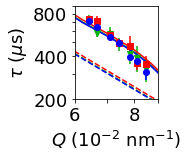

In [305]:
x = qs[2:,:] 
if fun==1:
    y = tau[2:,:]/unit # s
    yerr = tau_errors[2:,:]/unit # s
elif fun==2:
    y = (tau[2:,:] / kww[2:,:] * gamma(1/kww[2:,:]))/unit # s
    yerr = (tau_errors[2:,:] * np.abs(1/kww[2:,:]) + kww_errors[2:,:] * np.abs(-tau[2:,:]/kww[2:,:]**2 * gamma(1/kww[2:,:]) + tau[2:,:]/kww[2:,:] * -1/kww[2:,:]**2 * gamma(1/kww[2:,:])*polygamma(0,1/kww[2:,:])))/unit # s
    kwws = kww[2:,:]
    kwws_err = kww_errors[2:,:]
    
#print([x, y*unit, yerr*unit])
#np.save('tau_data_dmso', [x, y*unit, yerr*unit])

D = np.empty((3))
Derr = np.empty((3))

def tau_fit(x,a):
    return (1/a)*x 

#########################################
fig, ax = plt.subplots(figsize=(1.5,1.7))
col = ['b','r',[0,0.7,0]]

for i in [2, 1, 0]:
    
    for j in range(len(x)):
        ax.errorbar(x[j,i]*1e2, y[j,i]*unit, yerr=yerr[j,i]*unit, fmt=symbol[i], ms=6, color=col[i])

    # convoluted model tau
    fname = 'NPdmso_'+str(i)+'.npy'
    Q_av_tau = np.load('Q_av_tau_'+fname)
    tau_av = np.load('tau_av_'+fname) # convoluted model
    tau0_av = np.load('tau0_av_'+fname) # model without convolution
    plt.plot(Q_av_tau[:]*1e2,tau_av[:]*unit, '-', lw=1.5, color=col[i], label=r'$\tau_{model, conv.}$') # color='dodgerblue',
    plt.plot(Q_av_tau[:]*1e2,tau0_av[:]*unit, '--', lw=1.5, color=col[i], label=r'$\tau_{model}$')
    
ax.set_xlabel(r'$Q$ ($10^{-2}$ nm$^{-1}$)', size=18)
ax.set_ylabel(r'$\tau$ ($\mu$s)', size=18)
ax.tick_params(labelsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['','6','','8','','10','','12'])
ax.set_yticks([200,300,400,500,600,700,800,900,1000])
ax.set_yticklabels(['200','','400','','','','800','',''])
plt.xlim([6,9])
plt.ylim([200,900])

#plt.savefig('tau_'+'dmso'+solvent+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

print(D, Derr)
plt.show()

### kww exponents

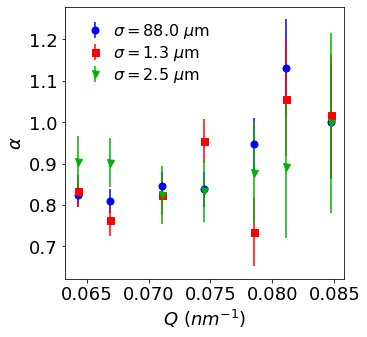

In [1439]:
fig, ax = plt.subplots(figsize=(5,5))

for i in range(3):
    
    ax.errorbar(x[:,i], kwws[:,i], yerr=kwws_err[:,i], fmt=symbol[i], ms=7, color=col[i], label=r'$\sigma = %.1f$ $\mu$m' %(beam[i])) 
    
ax.set_xlabel(r'$Q~(nm^{-1})$', size=18)
ax.set_ylabel(r'$\alpha$', size=18)
ax.tick_params(labelsize=18)
plt.legend(frameon=False, loc='upper left', fontsize=16, labelspacing=0.2, handletextpad=0.1)

#plt.savefig('kww_'+'dmso_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

In [2107]:
for i in range(3):
    kww_av = np.average(kww[:,i], weights=1/kww_errors[:,i]**2) 
    kww_std = np.sqrt(np.average((kww[:,i]-kww_av)**2, weights=1/kww_errors[:,i]**2))
    print(kww[:,i], kww_errors[:,i], kww_av, kww_std)

[0.81581271 0.84946937 0.82780515 1.00797506 0.86760493] [0.02682339 0.02016758 0.02327615 0.07008495 0.10018148] 0.8406842448120612 0.034468601408969526
[0.84936209 0.84339279 0.88015267 1.00515301 0.60128614] [0.03533093 0.02874524 0.03169306 0.09753669 0.10922077] 0.8553104745459916 0.05182662071294419
[0.86099642 0.87649915 0.77482849 0.9582583  1.02867797] [0.05715487 0.04073227 0.04587045 0.12608969 0.22971751] 0.845775540979653 0.05516911136416556
